In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

In [2]:
import re
import torch
import seaborn as sns

from machine.util.checkpoint import Checkpoint
from machine.dataset import SourceField, TargetField, get_standard_iter

no display found. Using non-interactive Agg backend


In [3]:
checkpoint_path = '../../models/b9da0a07f7e442afbc0e70345111998d/s8760'
checkpoint = Checkpoint.load(checkpoint_path)
seq2seq = checkpoint.model
seq2seq.eval()
input_vocab = checkpoint.input_vocab
output_vocab = checkpoint.output_vocab

In [4]:
output_eos_used = True
src = SourceField()
tgt = TargetField(output_eos_used)

tabular_data_fields = [('src', src), ('tgt', tgt)]

src.vocab = input_vocab
tgt.vocab = output_vocab
tgt.eos_id = tgt.vocab.stoi[tgt.SYM_EOS]
tgt.sos_id = tgt.vocab.stoi[tgt.SYM_SOS]
max_len = 50

Option batch_first has to be set to use machine.  Changed to True.


In [5]:
print('Input vocab:', list(src.vocab.itos))
print('Output vocab:', list(tgt.vocab.itos))

Input vocab: ['<unk>', '<pad>', 'left', 'right', 'thrice', 'twice', 'around', 'opposite', 'after', 'and', 'jump', 'look', 'run', 'walk', 'turn']
Output vocab: ['<unk>', '<pad>', 'I_TURN_RIGHT', 'I_TURN_LEFT', 'I_JUMP', 'I_LOOK', 'I_RUN', 'I_WALK', '<eos>', '<sos>']


Output: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT


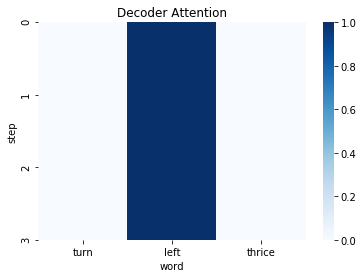

In [6]:
input_text = 'turn left thrice'
input_text_split = input_text.split()
input_variable, input_lengths = src.process([input_text_split])
target_variable = {}
with torch.no_grad():
    decoder_outputs, decoder_hidden, other = seq2seq(input_variable, input_lengths, target_variable)
    
output_words_idxs = torch.cat(decoder_outputs).argmax(1)
output_words = [tgt.vocab.itos[i] for i in output_words_idxs]
output_text = ' '.join(output_words)
output_text = re.sub(r'( <eos>)*$', '', output_text)
print('Output:', output_text)

attn = torch.cat(other['attention_score']).squeeze(1)
n_tokens = len(output_text.split())
attn = attn[:n_tokens]
ax = sns.heatmap(attn, cmap="Blues", xticklabels=input_text_split)
_ = ax.set(title='Decoder Attention', xlabel='word', ylabel='step')